# Testing SVM model with Stanford Data using Cross Validation with 10-fold split

In [164]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import sqlite3 as sql
from sklearn.svm import SVR, SVC
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
features = ["mean_elmo_redundancy",
            "mean_use_redundancy",
            "max_elmo_redundancy",
            "max_use_redundancy",
            "unigram_repetitions",
            "bigram_repetitions",
            "trigram_repetitions",
            "lrs_score",
            "adversarial_redundancy_score"]

In [2]:
conn = sql.connect("../../data/system_summaries.db")
df = pd.read_sql("SELECT * FROM system_summaries", conn)
conn.close()

In [3]:
_unique_vals, indices = np.unique([row.system + str(row.id) for _, row in df.iterrows()], return_index=True)
averaged_df = df.iloc[indices].sort_index()
avg_redundancy_scores = []
for index, row in averaged_df.iterrows():
    all_scores = df[(row.id == df.id) & (row.system == df.system)].redundancy
    avg_redundancy_scores.append(np.mean(all_scores))

In [4]:
df = averaged_df
df['redundancy'] = avg_redundancy_scores

In [5]:
training_set = df.sample(frac=(4/5), random_state=33)
test_set = df[~df.index.isin(training_set.index)]

# Training and Testing Lasso Regression

In [121]:
lasso_reg_alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
lasso_reg_param_grid = {'alpha': lasso_reg_alphas, "normalize": [True]}
lasso_grid_search = GridSearchCV(Lasso(), lasso_reg_param_grid, cv=5, scoring="neg_mean_squared_error")
lasso_grid_search.fit(training_set[features].values,
                training_set.redundancy)
print(lasso_grid_search.best_params_)

{'alpha': 0.0001, 'normalize': True}


In [122]:
lasso_reg = Lasso(alpha=0.0001, normalize=True)
lasso_reg.fit(training_set[features].values,
    training_set.redundancy)
lasso_preds = lasso_reg.predict(test_set[features].values)
print(pearsonr(lasso_preds,
         test_set.redundancy))
print(spearmanr(lasso_preds,
         test_set.redundancy))

(0.73425170612442614, 9.0500285572593538e-69)
SpearmanrResult(correlation=0.73725318384376537, pvalue=1.3327851629551775e-69)


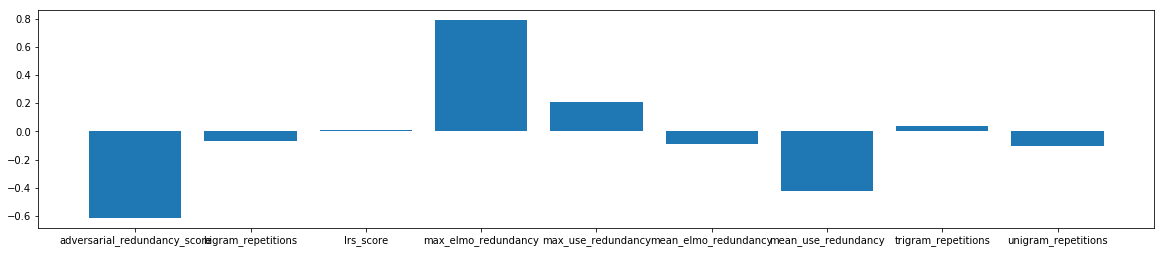

In [130]:
plt.figure(figsize=(20,4))
plt.bar(features, lasso_reg.coef_, )
plt.show()

In [131]:
r2_score(y_pred=ridge_preds, y_true=test_set.redundancy)

0.51269090974229226

# Training and Testing Support Vector Machines

In [124]:
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10]
gammas = ["auto", 0.001, 0.01, 0.1, 1]
rbf_param_grid = {'C': Cs, 'gamma': gammas, 'kernel': ["rbf"]}
rbf_grid_search = GridSearchCV(SVR(), rbf_param_grid, cv=5, scoring="neg_mean_squared_error")
rbf_grid_search.fit(training_set[features].values,
                training_set.redundancy)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'gamma': ['auto', 0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [126]:
Cs = [0.001, 0.01, 0.1, 1]
gammas = ["auto", 0.001, 0.01, 0.1]
degrees = [2, 3]
poly_param_grid = {'C': Cs, 'gamma': gammas, 'kernel': ["poly"], "degree": degrees}
poly_grid_search = GridSearchCV(SVR(), poly_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
poly_grid_search.fit(training_set[features].values,
                training_set.redundancy)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1], 'gamma': ['auto', 0.001, 0.01, 0.1], 'kernel': ['poly'], 'degree': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [127]:
poly_grid_search.best_score_

-0.26201964732055405

In [125]:
rbf_grid_search.best_score_

-0.22505549430591459

In [113]:
rbf_grid_search.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

The RBF Kernel Performs much better so we will use its best parameters.

In [132]:
sv_reg = SVR(C=10, gamma=0.01, kernel='rbf')
sv_reg.fit(training_set[features].values,
    training_set.redundancy)
svm_preds = sv_reg.predict(test_set[features].values)
print(pearsonr(svm_preds,
         test_set.redundancy))
print(spearmanr(svm_preds,
         test_set.redundancy))

(0.760299904167271, 2.1556971759160781e-76)
SpearmanrResult(correlation=0.74494477176428497, pvalue=8.7063877856299008e-72)


In [133]:
r2_score(y_pred=svm_preds, y_true=test_set.redundancy)

0.55872088970455347

Now, what happens when we perform some feature selection based off the coefficients from the ridge Regression?
- Remove
    - lrs_score
    - trigram_repetitions
    - bigram_repetitions
    - mean_elmo_redundancy

In [141]:
selected_features = ["mean_use_redundancy",
                     "max_elmo_redundancy",
                     "max_use_redundancy",
                     "unigram_repetitions",
                     "adversarial_redundancy_score"]


# Training Support Vector Machine with Feature Selection

In [142]:
rbf_grid_search2 = GridSearchCV(SVR(), rbf_param_grid, cv=5, scoring="neg_mean_squared_error")
rbf_grid_search2.fit(training_set[selected_features].values,
                training_set.redundancy)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'gamma': ['auto', 0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [145]:
poly_grid_search2 = GridSearchCV(SVR(), poly_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
poly_grid_search2.fit(training_set[selected_features].values,
                training_set.redundancy)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1], 'gamma': ['auto', 0.001, 0.01, 0.1], 'kernel': ['poly'], 'degree': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [146]:
poly_grid_search2.best_score_

-0.25863197580754943

In [143]:
rbf_grid_search2.best_score_

-0.22444161701224161

In [149]:
rbf_grid_search2.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [153]:
sv_reg2 = SVR(C=10, gamma=0.01, kernel='rbf')
sv_reg2.fit(training_set[selected_features].values,
    training_set.redundancy)
svm_preds2 = sv_reg2.predict(test_set[selected_features].values)
print(pearsonr(svm_preds,
         test_set.redundancy))
print(spearmanr(svm_preds,
         test_set.redundancy))

(0.7506530484974917, 1.8484858443224917e-73)
SpearmanrResult(correlation=0.71940106718044428, pvalue=8.1608981714720518e-65)


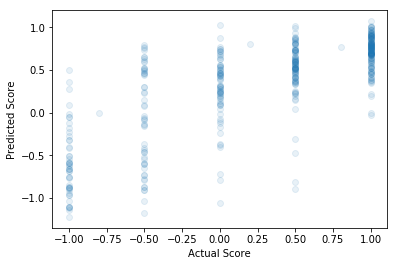

In [161]:
plt.scatter(test_set.redundancy, svm_preds2, alpha=.1)
plt.ylabel("Predicted Score")
plt.xlabel("Actual Score")
plt.show()

In [160]:
r2_score(y_pred=svm_preds2, y_true=test_set.redundancy)

0.55059094599676972